# AirBnb Fist booking prediction

### The main goal of this competition is to predict the first booking destination

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import datetime
import seaborn as sns
from scipy import stats
from scipy import integrate
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
plt.style.use('ggplot')

## Explore Data : 

In [4]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
train_users = pd.read_csv('train_users_2.csv')
test_users = pd.read_csv('test_users.csv')

In [6]:
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [7]:
countries = pd.read_csv('countries.csv')

In [8]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Data columns (total 7 columns):
country_destination              10 non-null object
lat_destination                  10 non-null float64
lng_destination                  10 non-null float64
distance_km                      10 non-null float64
destination_km2                  10 non-null float64
destination_language             10 non-null object
language_levenshtein_distance    10 non-null float64
dtypes: float64(5), object(2)
memory usage: 640.0+ bytes


In [9]:
countries.tail()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


In [10]:
test_users = pd.read_csv('test_users.csv')

In [11]:
train_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 27.7+ MB


In [12]:
print("We have :",train_users.shape[0],"users in train data with ",train_users.shape[1]," variables and ",test_users.shape[0]," in the test data")

('We have :', 213451, 'users in train data with ', 16, ' variables and ', 62096, ' in the test data')


In [13]:
print("# users ",train_users.shape[0]+train_users.shape[1])

('# users ', 213467)


In [14]:
test_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [15]:
sessions = pd.read_csv('sessions.csv')

In [16]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


In [17]:
sessions.describe()

,secs_elapsed
count,10431706.000000
mean,19405.810751
std,88884.243209
min,0.000000
25%,229.000000
50%,1147.000000
75%,8444.000000
max,1799977.000000


In [18]:
sessions[sessions.user_id == "d1mm9tcy42"].count()

user_id          127
action           126
action_type       90
action_detail     90
device_type      127
secs_elapsed     126
dtype: int64

## Missing Data
We should detect the missing data and replace them with Nan, if we see the gender colomun of train_users, we can show that we have a lot of -unkonown- value in the gender column : 

In [19]:
train_users.gender.replace('-unknown-',np.nan, inplace=True)

In [56]:
train_users.head()
corr = train_users.corr()
corr.describe

<bound method DataFrame.describe of                         timestamp_first_active       age  signup_flow
timestamp_first_active                1.000000 -0.035961     0.196702
age                                  -0.035961  1.000000    -0.018609
signup_flow                           0.196702 -0.018609     1.000000>

Lets show the number of missing gender for example

In [21]:
print("The number of missing gender user is ", train_users.gender.isnull().sum())
print("The total number of train_user is : ",train_users.shape[0])
print("The number of missing age in train_user is : ",train_users.age.isnull().sum())

('The number of missing gender user is ', 95688)
('The total number of train_user is : ', 213451)
('The number of missing age in train_user is : ', 87990)


In [22]:
users_nan = (train_users.isnull().sum()/train_users.shape[0])*100
users_nan[users_nan > 0].head()

date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_affiliate_tracked     2.841402
dtype: float64

In [23]:
train_users.date_first_booking.describe()

count          88908
unique          1976
top       2014-05-22
freq             248
Name: date_first_booking, dtype: object

In [24]:
print("The number of minor users is : ",sum(train_users.age < 18))

('The number of minor users is : ', 158)


In [25]:
print("The number of users superior than 120 years is ",sum(train_users.age > 122))

('The number of users superior than 120 years is ', 781)


So, we have 158 dosn't respect the politic of Airbnb and 781 with more than 122 years

In [26]:
train_users[train_users.age > 122].describe()

,timestamp_first_active,age,signup_flow
count,7.810000e+02,781.000000,781.000000
mean,2.012670e+13,2006.308579,1.610755
std,9.289315e+09,95.711349,5.175840
min,2.010041e+13,132.000000,0.000000
25%,2.012061e+13,2014.000000,0.000000
50%,2.013032e+13,2014.000000,0.000000
75%,2.013093e+13,2014.000000,0.000000
max,2.014063e+13,2014.000000,25.000000


In [27]:
train_users[train_users.age < 18].describe()

,timestamp_first_active,age,signup_flow
count,1.580000e+02,158.000000,158.000000
mean,2.012341e+13,12.202532,2.917722
std,1.660633e+10,5.916359,5.799149
min,2.010031e+13,1.000000,0.000000
25%,2.010091e+13,5.000000,0.000000
50%,2.013062e+13,16.000000,0.000000
75%,2.014021e+13,17.000000,2.000000
max,2.014063e+13,17.000000,25.000000


## Visualizing data
We Will try to present our data depending to different kind of features

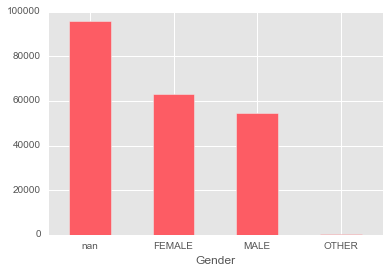

In [28]:
train_users.gender.value_counts(dropna=False).plot(kind='bar',color='#FD5C64',rot = 0)
plt.xlabel("Gender")
sns.despine()

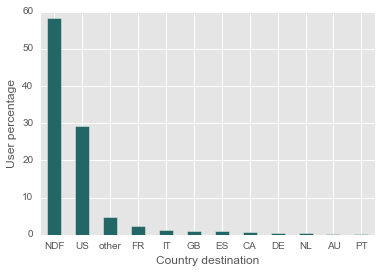

In [29]:
destination_percentage = train_users.country_destination.value_counts() / train_users.shape[0]*100
destination_percentage.plot(kind='bar',color='#226666',rot=0)
plt.xlabel("Country destination")
plt.ylabel("User percentage")
sns.despine()

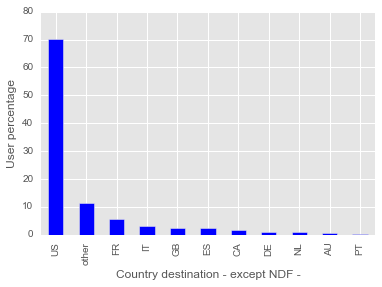

In [30]:
train_users_except_ndf = train_users[train_users.country_destination != "NDF"]
destination_percentage = train_users_except_ndf.country_destination.value_counts() / train_users_except_ndf.shape[0]*100
destination_percentage.plot(kind='bar')
plt.xlabel("Country destination - except NDF -")
plt.ylabel("User percentage")
sns.despine()

As we can see all 12 classes are represented in the training data and we can see that nearly <b> 60% of users do not make a booking </b>. Of the users that book, about <b>70 % do so in the US</b>.

## Languages 

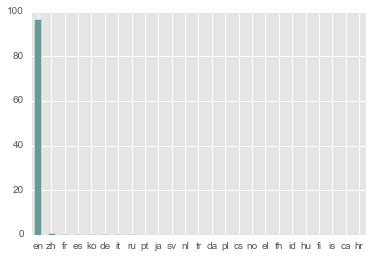

In [31]:
user_languages = train_users.language.value_counts() / train_users.shape[0] * 100
user_languages.plot(kind='bar',color='#689999',rot=0)

In [32]:
countries.count

<bound method DataFrame.count of   country_destination  lat_destination  lng_destination  distance_km  \
0                  AU       -26.853388       133.275160   15297.7440   
1                  CA        62.393303       -96.818146    2828.1333   
2                  DE        51.165707        10.452764    7879.5680   
3                  ES        39.896027        -2.487694    7730.7240   
4                  FR        46.232193         2.209667    7682.9450   
5                  GB        54.633220        -3.432277    6883.6590   
6                  IT        41.873990        12.564167    8636.6310   
7                  NL        52.133057         5.295250    7524.3203   
8                  PT        39.553444        -7.839319    7355.2534   
9                  US        36.966427       -95.844030       0.0000   

   destination_km2 destination_language   language_levenshtein_distance  
0          7741220                   eng                           0.00  
1          9984670        

## Gender : 

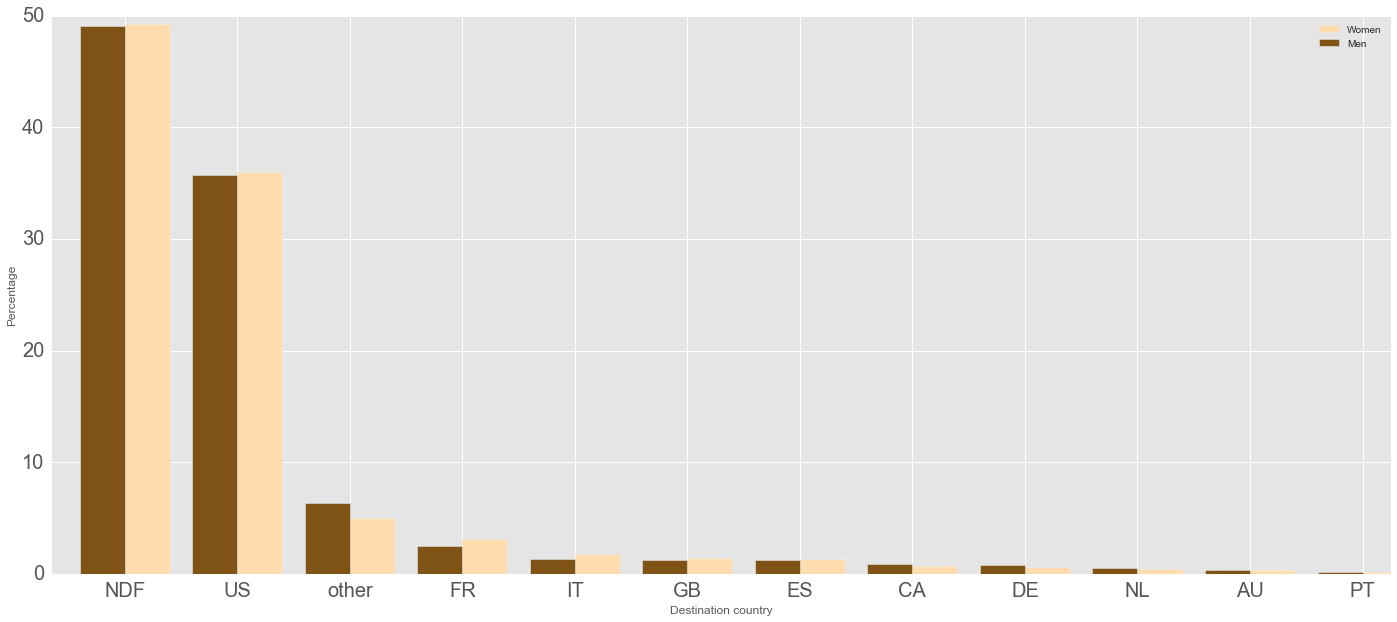

In [33]:
women = sum(train_users.gender == 'FEMALE')
men = sum(train_users.gender == 'MALE')

female_destination = train_users.loc[train_users.gender == 'FEMALE', 'country_destination'].value_counts() / women *100
men_destination = train_users.loc[train_users.gender == 'MALE','country_destination'].value_counts() / men * 100

width = 0.4

female_destination.plot(kind = 'bar', width=width, rot=0, color='#ffdcad', label='Women', position=0,figsize=(24,10))
men_destination.plot(kind='bar',width=width,rot=0,color='#7f5215',label='Men',position=1,figsize=(24,10),fontsize=20)

plt.xlabel("Destination country")
plt.ylabel("Percentage")
plt.legend()
plt.show()

We can say that there is <b>no difference</b> between the two gender, so this figure isn't verry useful ! 

## Age
Lets see now the influence of the age :

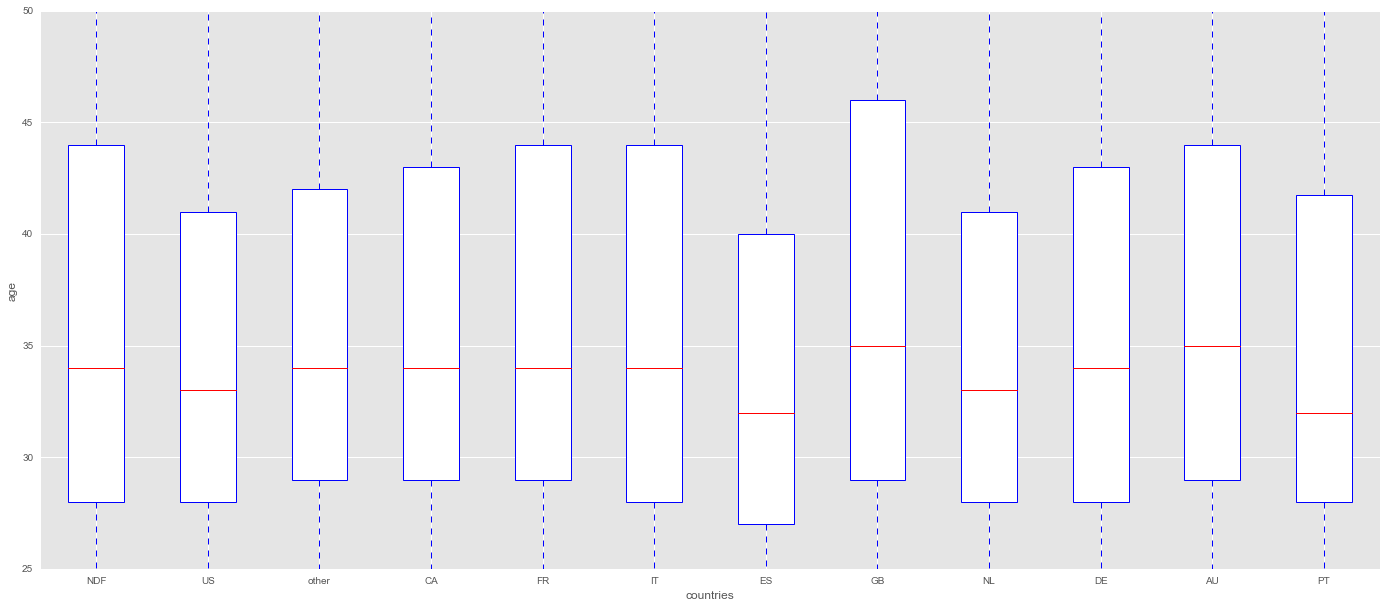

In [34]:
train_users_age  = train_users[np.isfinite(train_users['age'])]
countries = train_users_age.country_destination.unique()
data_to_plot = []

## create the dataplot from the train users dataframe
for country in countries:
    data_to_plot.append(train_users_age[train_users_age.country_destination == country].age)

## create a figure instance
fig = plt.figure(1,figsize(24,10))
# Create an axes instance
ax = fig.add_subplot(111)

## colors 
## colors = ['pink', 'lightblue', 'lightgreen','lightblue','lightgreen','lightcyan','magenta','lightyellow','lightgray','black']

# Create the boxplot
bp = ax.boxplot(data_to_plot,vert=True,patch_artist=True)

#for patch, color in zip(bp['boxes'], colors):
#    patch.set_facecolor(color)
            
## Custom x-axis labels
ax.set_xticklabels(train_users_age.country_destination.unique())


plt.xlabel("countries")
plt.ylabel("age")
plt.ylim([25,50])
plt.show()

The age show some interesting differentiation by country destination that could be useful. Users how book trips to <b> Spain </b> and <b> Portugal </b> tend to be younger while those that book trips to <b>Great Britain</b> or <b> United States</b>.

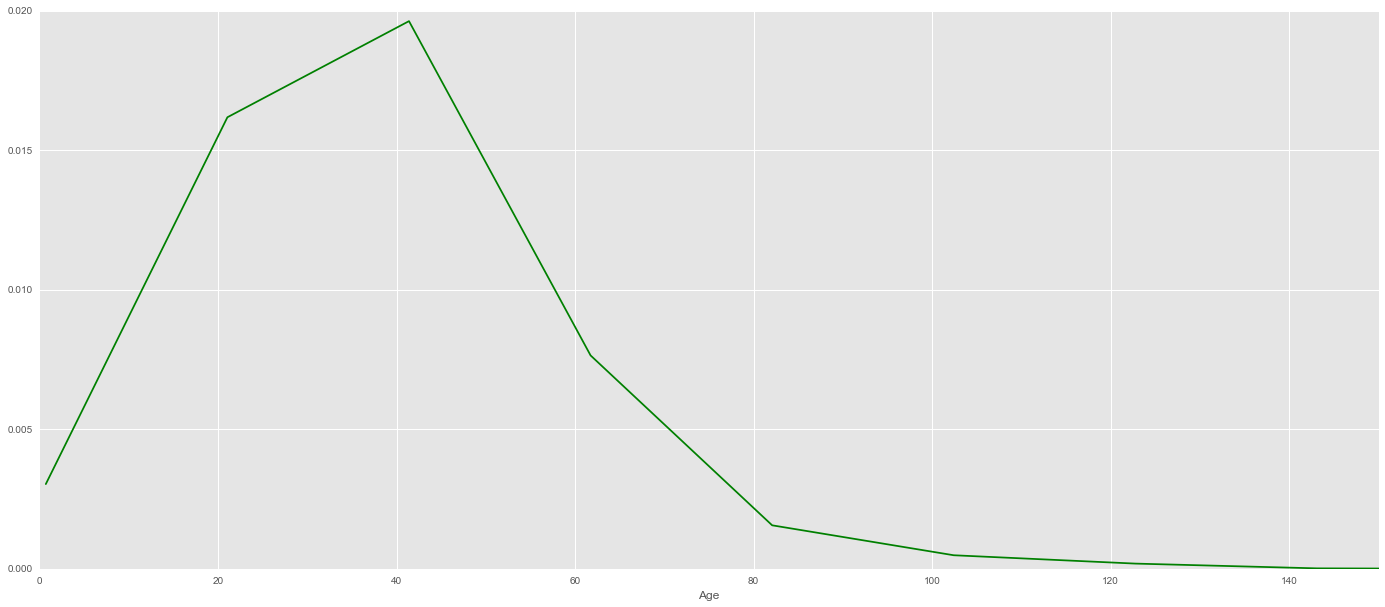

In [35]:
sns.distplot(train_users.age.dropna(),hist=False,color="g")
plt.xlabel('Age')
plt.xlim([0,150])
sns.despine()

We can say that the majority of people book between 30 and 50 years, Lets now plot the <b> age by destination density </b> for differents countries that we have : 

In [36]:
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


Lets now try to plot the <b>age density and the country destination of users</b>, we can say if the age is decisif or not of the choice of country destination of Airbnb users : 

In [37]:
age_country_users = pd.concat([train_users['age'],train_users['country_destination']],axis=1,keys=['age','country_destination'])
age_country_users = age_country_users[np.isfinite(age_country_users['age'])]

Use the <b>KDE (Kernet Density Estimator)</b> using <b> Gaussian Kernel</b> in order to estimate the probability density function of age variable in non parametric way, the goal is to plot the density of people how book depending of out age, We can evalue the quality of this estimator : 

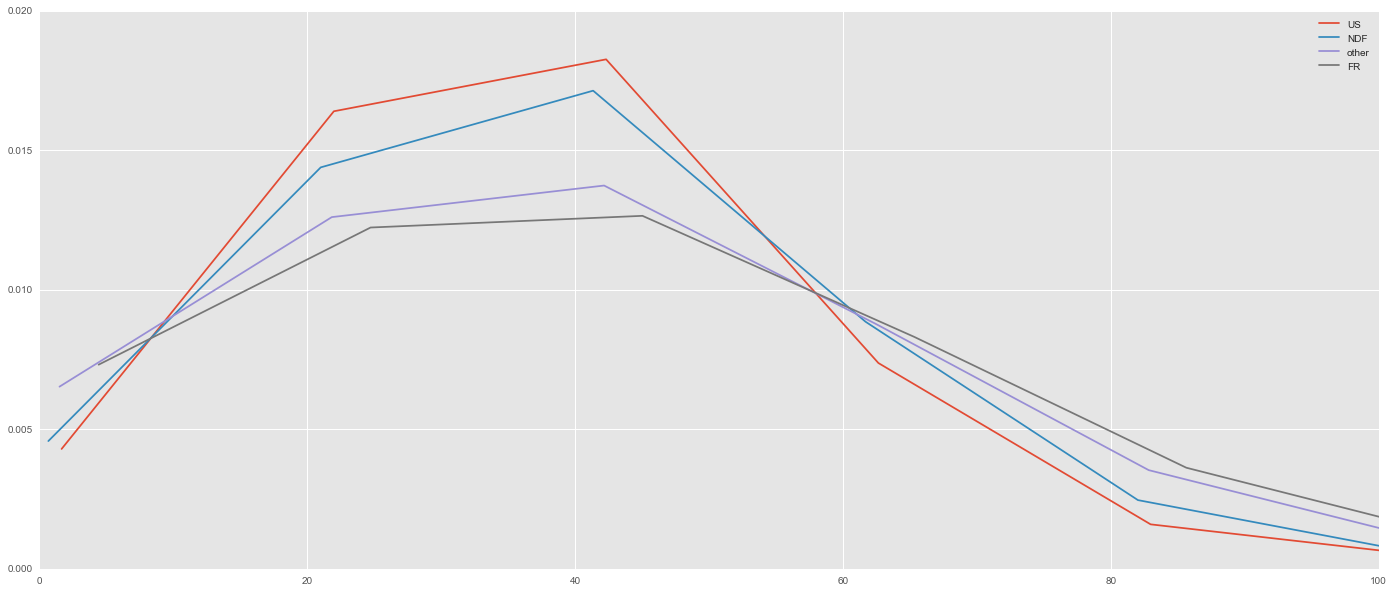

In [38]:
sns.kdeplot(age_country_users[age_country_users.country_destination == "US"].age,label="US")
sns.kdeplot(age_country_users[age_country_users.country_destination == "NDF"].age,label="NDF")
sns.kdeplot(age_country_users[age_country_users.country_destination == "other"].age,label="other")
sns.kdeplot(age_country_users[age_country_users.country_destination == "FR"].age,label="FR")
plt.xlim([0,100])
plt.legend()

In [39]:
kde = stats.gaussian_kde(age_country_users[age_country_users.country_destination == "US"].age)
array = kde.evaluate(age_country_users[age_country_users.country_destination == "US"].age)

In [40]:
print "The quality of the Kernel Density Estimator using the Gaussian Kernel for US destination is : ",(1-np.median(array))*100, "% It's PERFECT !"

The quality of the Kernel Density Estimator using the Gaussian Kernel for US destination is :  98.0878646945 % It's PERFECT !


# Date visualization : 
## First booking date visualization : 
The goal is to visualize the <b>number of booking by date</b>

(0, 260)

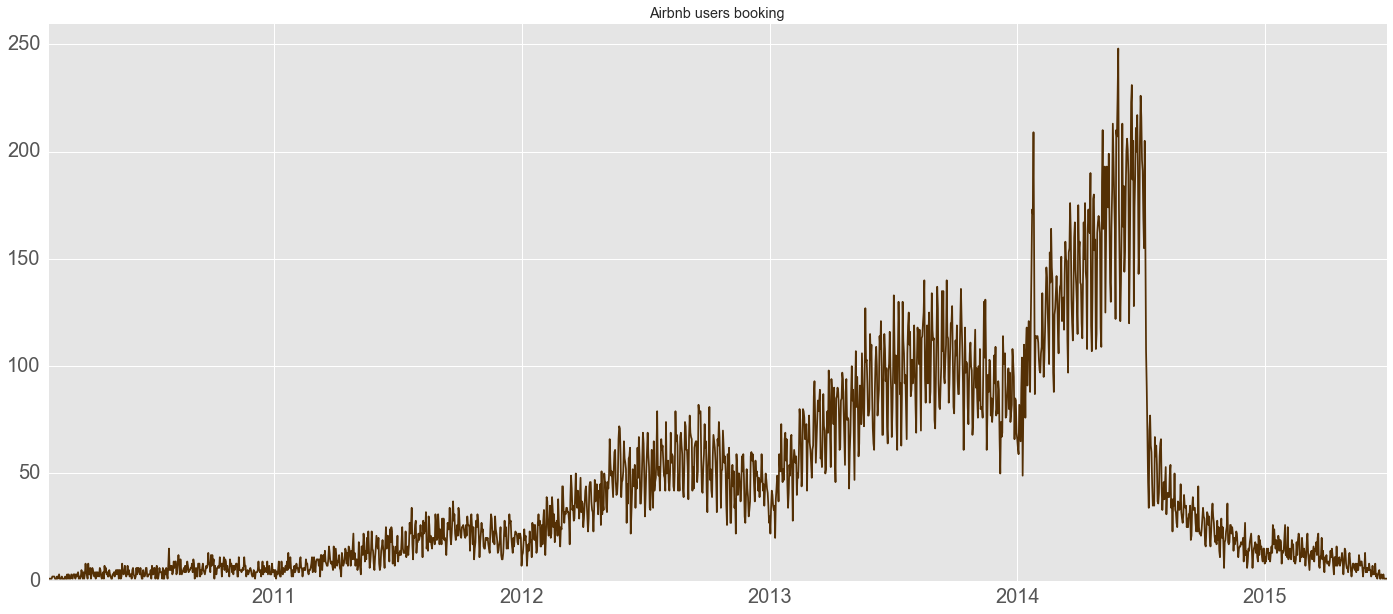

In [41]:
book_user = train_users.dropna(subset=['date_first_booking']) #Delete NaN value from date_first_booking column
df =  book_user.groupby(['date_first_booking']).size().reset_index()
ts = pd.Series(df[0].values, index=pd.date_range(start='2/1/2010', end='30/6/2015'))
ax  = ts.plot(title="Airbnb users booking",colormap='BrBG',figsize=(24,10),fontsize=20)
#ax.set_xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-6-30'))
ax.set_ylim(0,260)
#df.describe()

## Signup date visualization : 
We will try to show the number of signup by day : 

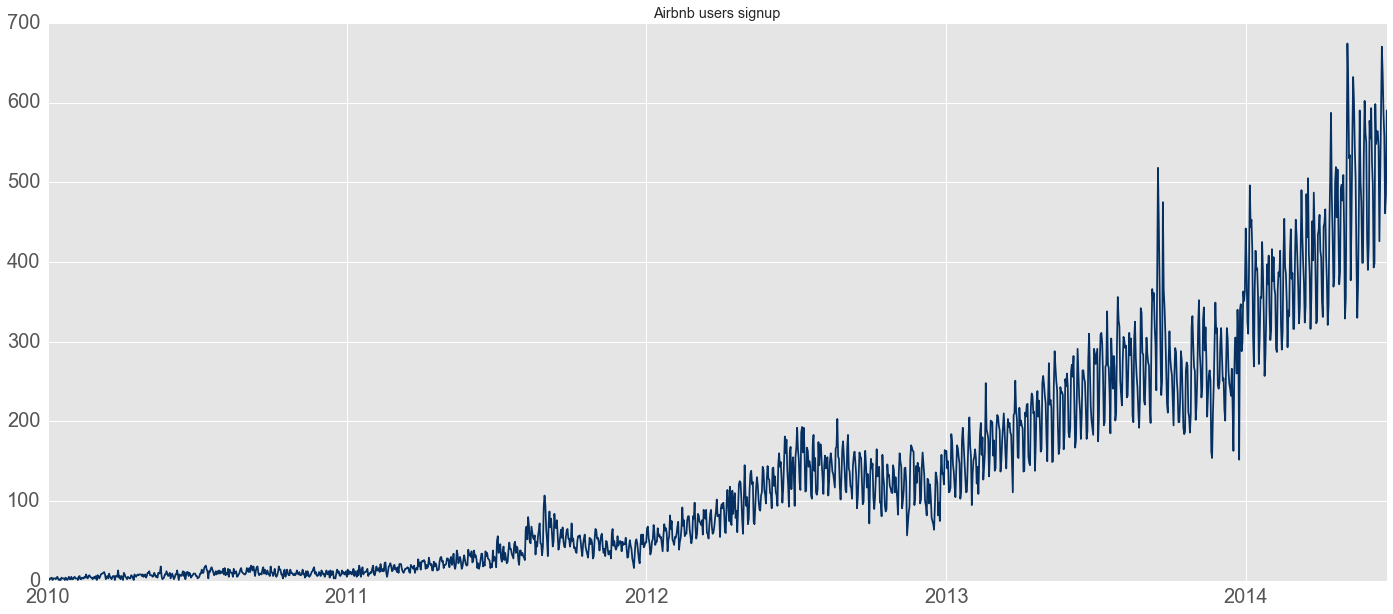

In [42]:
df =  train_users.groupby(['date_account_created']).size().reset_index()
ts = pd.Series(df[0].values, index=pd.date_range('1/1/2010', periods=1634))
ax  = ts.plot(title="Airbnb users signup",colormap='RdBu_r',figsize=(24,10),fontsize=20)

## Signup method visualizing : 

In [43]:
train_users.signup_method.unique()

array(['facebook', 'basic', 'google'], dtype=object)

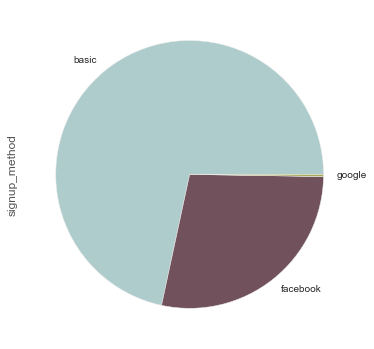

In [44]:
signup_percentage = train_users.signup_method.value_counts()/train_users.shape[0]*100;
colors = ['#AFCCCC', '#71525C', '#AAA95A']
signup_percentage.plot(kind='pie',figsize=(6,6),rot = 0,colors=colors)

## Sessions :

In [45]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


(0, 1000)

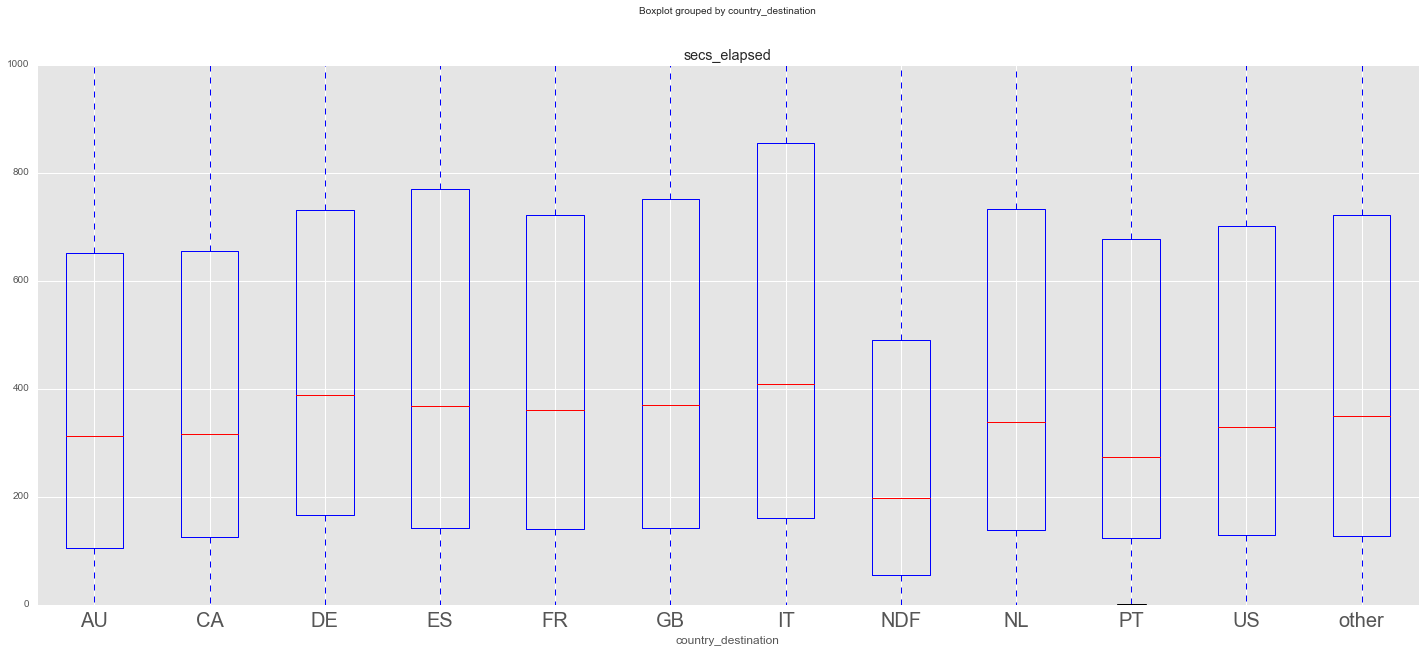

In [46]:
users_secs_elpased = sessions.groupby('user_id')['secs_elapsed'].sum().reset_index()
train = pd.concat([train_users.set_index('id'), sessions.groupby('user_id')['secs_elapsed'].sum()/3600], axis=1).reset_index()
train.boxplot(column='secs_elapsed',by='country_destination',figsize=(24,10),fontsize=20)
plt.ylim([0,1000])

We put the total of `secs elapsed` into a `df` from each user, the main goal of this approach is to plot the total of <b>secs elapsed depending if user book or not</b>, this approach can help us to define if its important to take care of time elapsed or not. We see that people how didn't book spen <b>less time</b> than those how book. We see also that people how book to Italy spend a lot of time compared to the other country destination.

(0, 2500)

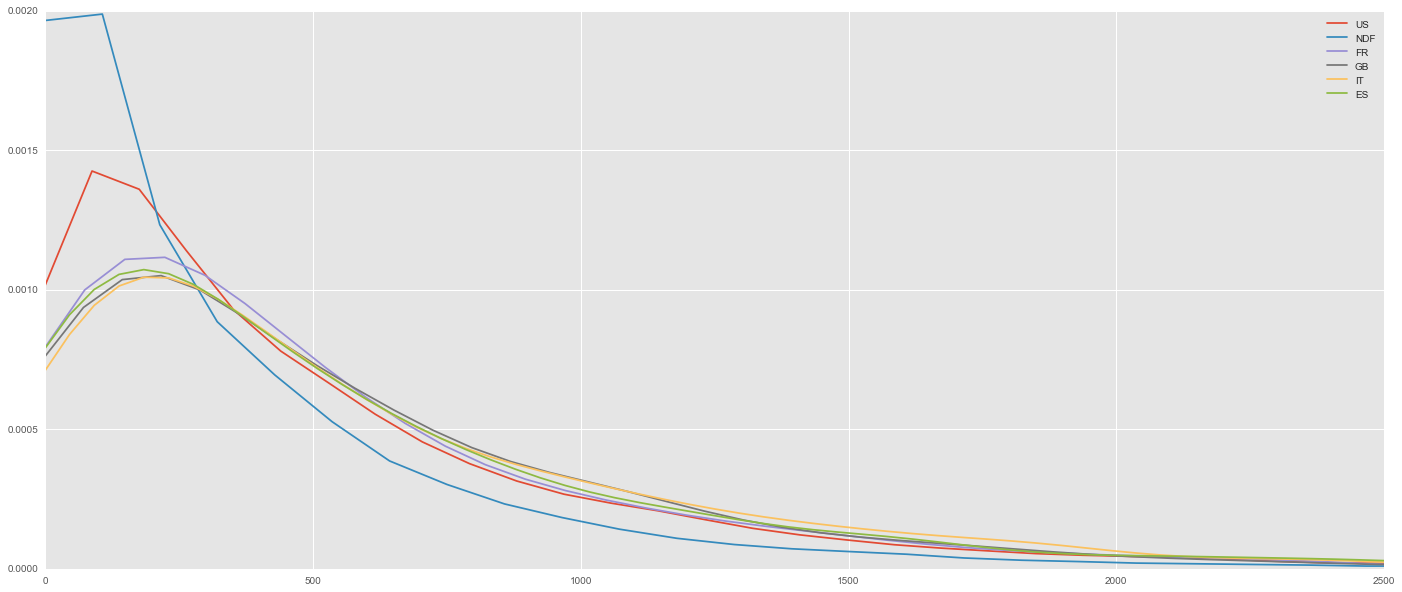

In [47]:
train = train[np.isfinite(train['secs_elapsed'])]
sns.kdeplot(train[train.country_destination == "US"].secs_elapsed,label="US")
sns.kdeplot(train[train.country_destination == "NDF"].secs_elapsed,label="NDF")
sns.kdeplot(train[train.country_destination == "FR"].secs_elapsed,label="FR")
sns.kdeplot(train[train.country_destination == "GB"].secs_elapsed,label="GB")
sns.kdeplot(train[train.country_destination == "IT"].secs_elapsed,label="IT")
sns.kdeplot(train[train.country_destination == "ES"].secs_elapsed,label="ES")
plt.xlim([0,2500])

## Feature engineering :  Preprocessing step and encoding categorical features using OneHotEncoder

In [48]:
categorical_columns = ['gender','signup_method','language','affiliate_channel','affiliate_provider','first_affiliate_tracked','signup_app','first_device_type','first_browser']

In [75]:
def encode_onehot(df, cols):
    """
    One-hot encoding is applied to columns specified in a pandas DataFrame.
    
    Modified from: https://gist.github.com/kljensen/5452382
    
    Details:
    
    http://en.wikipedia.org/wiki/One-hot
    http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
    
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    vec = DV()
    
    vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(outtype='records')).toarray())
    vec_data.columns = vec.get_feature_names()
    vec_data.index = df.index
    
    df = df.drop(cols, axis=1)
    df = df.join(vec_data)
    return df

In [76]:
df = encode_onehot(train_users,categorical_columns)
df = df.drop('date_first_booking', 1)
df = df.drop('date_account_created',1)
df = df.drop('id',1)
df.loc[df['country_destination'] =='NDF', 'country_destination'] = 0
df.loc[df['country_destination'] !=0, 'country_destination'] = 1
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: the 'outtype' keyword is deprecated, use 'orient' instead


## Logistic Regression : 
The goal of this approach is to define if a user <b>will book or not</b>, if the algorithm predict that user will book, we will try to determine <b>the country destination</b>.

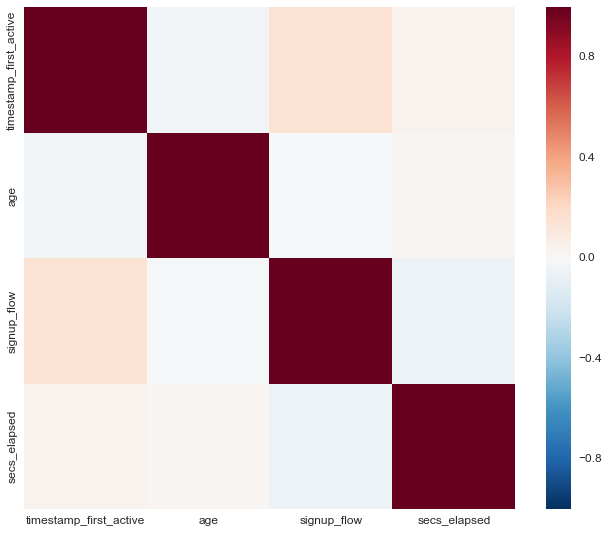

In [74]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
sns.set(style="white")
sns.set(font_scale=1.2)  # crazy big

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr)

#model.fit(train,train.country_destination)